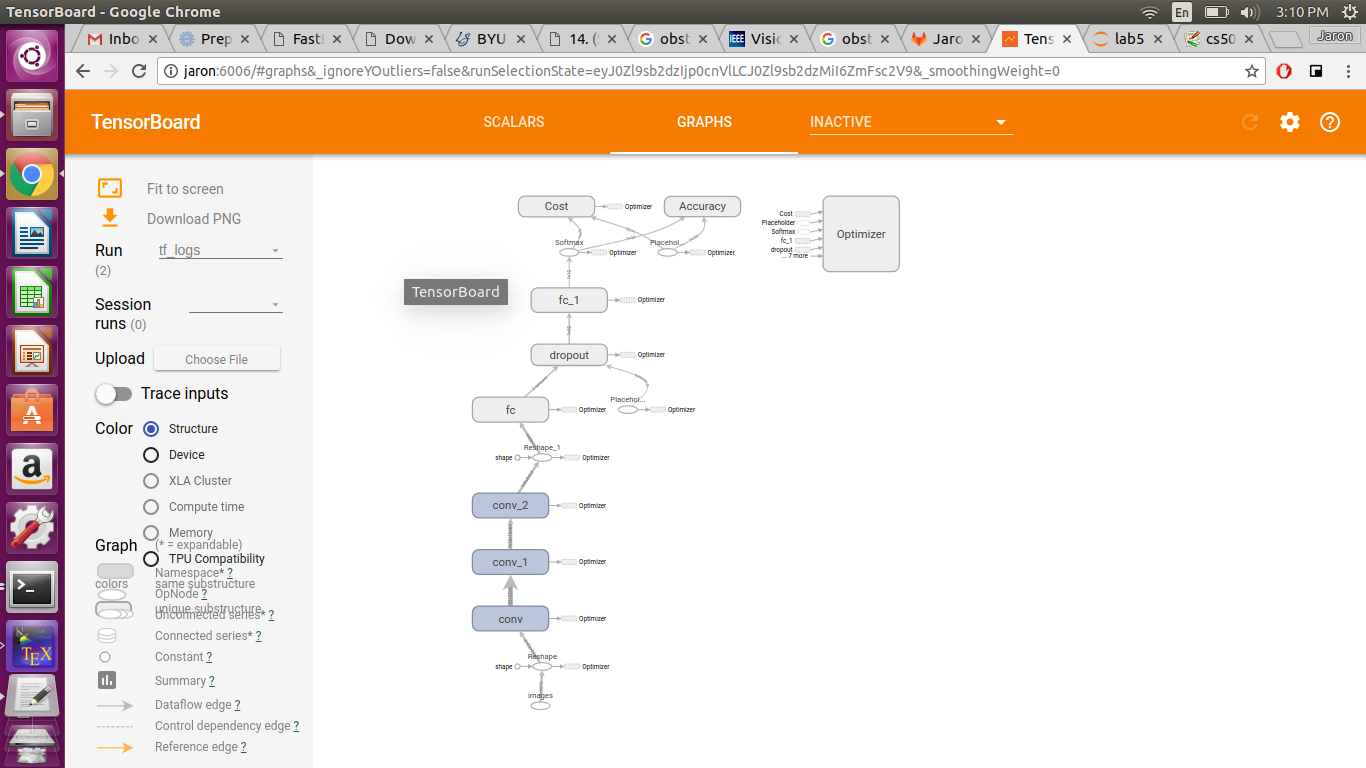

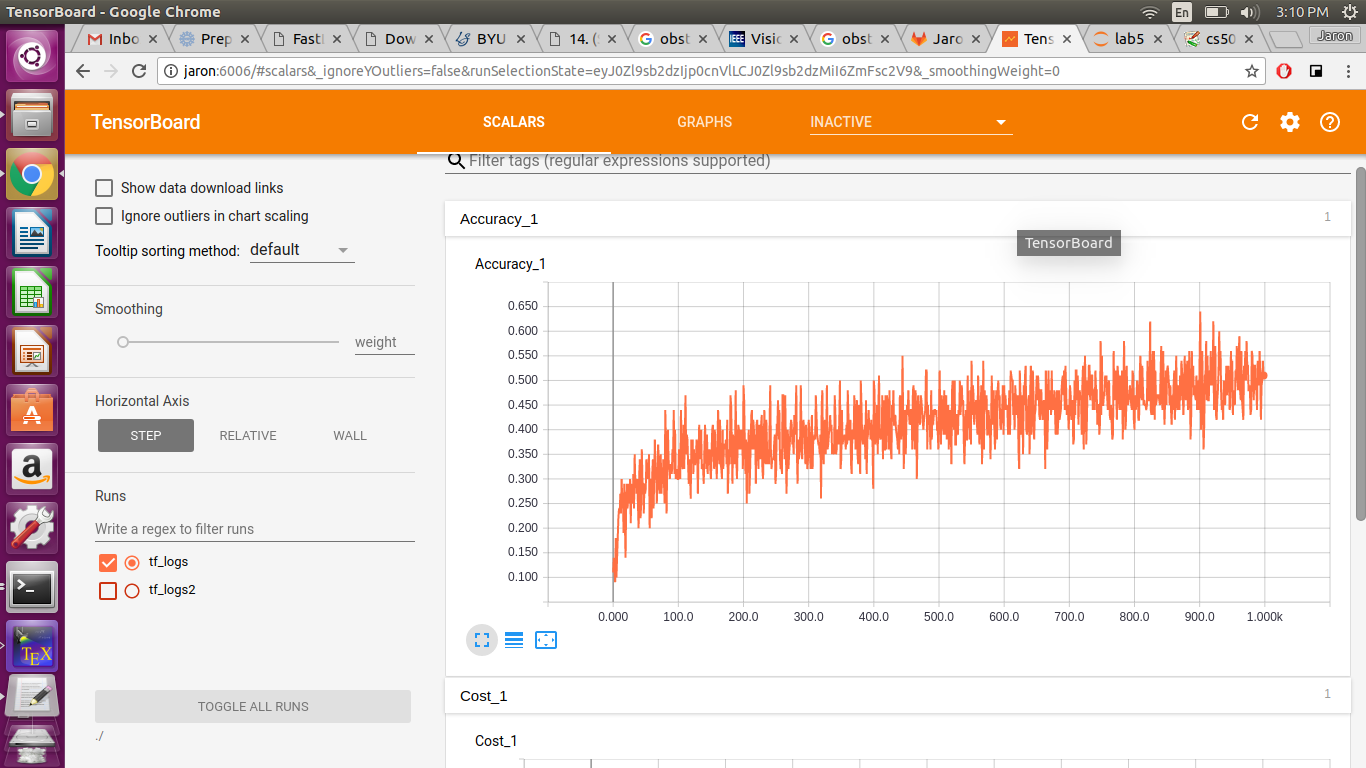

In [2]:
%matplotlib inline

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt


img = Image.open('lab5_graph.png')
img2 = Image.open('lab5_accuracy.png')

display(img)
display(img2)

In [ ]:
import numpy as np 
import tensorflow as tf
    
tf.reset_default_graph()
sess = tf.InteractiveSession()

def unpickle( file ):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict
 
data = unpickle( 'cifar-10-batches-py/data_batch_1' )

features = data['data']
labels = data['labels']

one_hot_labels = []
for label in labels:
    one_hot = np.zeros(10)
    one_hot.put(label,1)
    one_hot_labels.append(one_hot)

train_f = features[0:8000]
train_l = one_hot_labels[0:8000]
test_f = features[8000:10000]
test_l = one_hot_labels[8000:10000]

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.2)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv( x, filter_size=3, stride=1, num_filters=64, is_output=False, name="conv" ):
    
    with tf.name_scope(name) as scope:
        #W = weight_variable([filter_size, filter_size, x.get_shape().as_list()[3], num_filters])
        W = tf.Variable( 1e-3*np.random.randn(filter_size, filter_size, x.get_shape().as_list()[3], num_filters).astype(np.float32))
        b = bias_variable([num_filters])
        h = []
        
        if not is_output:
            h = tf.nn.relu(tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b)
        else:
            h = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b
        return h


def fc( x, out_size=50, is_output=False, name="fc" ):
    with tf.name_scope(name) as scope:
        #W = weight_variable( [x.get_shape().as_list()[1], out_size])
        W = tf.Variable( 1e-3*np.random.randn(x.get_shape().as_list()[1], out_size).astype(np.float32))
        b = bias_variable([out_size])
        h = []
        if not is_output:
            h = tf.nn.relu(tf.matmul(x,W)+b)
        else:
            h = tf.matmul(x,W)+b
        return h

x = tf.placeholder(tf.float32, shape=[None, 32*32*3], name="images")
label_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

x_image = tf.reshape(x, [-1,32,32,3])

h0 = conv(x_image)
h1 = conv(h0,stride=2)
h2 = conv(h1,stride=2)
shape = h2.get_shape().as_list()

flat = tf.reshape(h2,[-1,shape[1]*shape[2]*shape[3]])

fc1 = fc(flat)
fc1_drop = tf.nn.dropout(fc1, keep_prob)

fc2 = fc(fc1_drop,out_size=10,is_output=True)

label_conv = tf.nn.softmax(fc2)


with tf.name_scope('Cost') as scope:
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(label_ * tf.log(tf.clip_by_value(label_conv,1e-10,1)), reduction_indices=[1]))
    
with tf.name_scope('Accuracy') as scope:
    correct_prediction = tf.equal(tf.argmax(label_conv,1), tf.argmax(label_,1))
    label_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
with tf.name_scope('Optimizer') as scope:
    train_step = tf.train.AdamOptimizer(3e-6).minimize(cross_entropy)
    
acc_summary = tf.summary.scalar( 'Accuracy', label_acc )
cost_summary = tf.summary.scalar( 'Cost', cross_entropy )

merged_summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("./tf_logs2",graph=sess.graph)

sess.run(tf.global_variables_initializer())

NUM_EPOCHS = 1000
place = 0
test_place = 0


def train_get_batch(size):
    global place
    if size*place+50 > 8000-1:
        place = -1
    return train_f[0:size],train_l[0:size]
    place += 1
    return train_f[size*place:size*place+size], train_l[size*place:size*place+size] 

def test_get_batch(size):
    global test_place
    if size*test_place+50 > 2000-1:
        test_place = 0  
    test_place += 1
    return train_f[size*test_place:size*test_place+size], train_l[size*test_place:size*test_place+size] 

for i in range(NUM_EPOCHS):
    while place != -1:	
        batch = train_get_batch(50)
        train_step.run(feed_dict={x:batch[0], label_:batch[1], keep_prob:.5})
    place = 0 
    test_batch = test_get_batch(100)
    summary_str,l = sess.run([merged_summary_op, label_acc],feed_dict={x:test_batch[0], label_:test_batch[1], keep_prob:.5})
    
    print("%d, %g"%(i,l))
    summary_writer.add_summary(summary_str,i)
summary_writer.close()